# 2. Preprocessing
## 2.05 Preparing the data for the models

To avoid preprocessing the raw input data every time before running a model, we prepare the dataset in this notebook using the insights gained from the previous steps.

### Curse of dimensionality
There is one issue that you encounter when dealing with geospatial data: Basically you would want to use all the data you can get in order to achieve the best results with your model, but geospatial data with probably high spatial correlation introduces problems like overfitting the model on one predictor variable and destabilizes the resulting prediction model.

To roughly estimate the input space dimensionality, imagine using all ERA5 gridpoints of the upstream area of one point. For a 1.5x1.5 degree (lat,lon) grid, ERA5 provides 6 x 6 gridpoints. To take the time dimension into account we'd need about 180 days of precipitation, which sums to 6480 features. Compare that to a 20 year daily timeseries (~7300 samples), which clearly violates the rule of thumb of 10 features per sample and inhibits learning from data.

To work around that, we need to reduce the dimensionality by
- spatially aggregating and
- temporally aggregating the data

Both will be done in sections below.

In [17]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('../../')
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables, reshape_scalar_predictand, shift_and_aggregate

In [18]:
# load data
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
era5_2013 = xr.open_dataset('../../data/sampledata-2013-era5.nc')
glofas_2013 = xr.open_dataset('../../data/sampledata-2013-glofas.nc')

era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    sd           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

First of all, reduce the data spatially to the basin, interpolate era5 data onto the glofas grid and for the 2013 sample data, limit the relevant range (as determined from the general flow direction, eastward, and the approximate range of significant relevance from the spatial correlations).

In [19]:
danube_catchment = get_mask_of_basin(glofas['dis'].isel(time=0))
danube_catchment_2013 = get_mask_of_basin(glofas_2013['dis'].isel(time=0))
dis = glofas['dis'].where(danube_catchment)
dis_2013 = glofas_2013['dis'].where(danube_catchment_2013)

In [20]:
era5_basin = era5.interp(latitude=glofas.latitude,
                         longitude=glofas.longitude).where(danube_catchment)
era5_2013_basin = era5_2013.interp(latitude=glofas_2013.latitude,
                                   longitude=glofas_2013.longitude).where(danube_catchment_2013)

Limit longitude to 16 deg East for the 2013 sample data.

In [21]:
era5_2013_basin = era5_2013_basin.sel(longitude=slice(None, 16.))
dis_2013 = dis_2013.sel(longitude=slice(None, 16.))

Check if the spatial domain looks good.

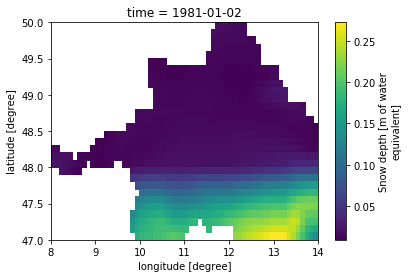

In [22]:
era5_basin['sd'].isel(time=1).plot()

Add the change in snow depth as additional variable.

In [23]:
sd_diff = era5_basin['sd'].diff(dim='time')
sd_diff.name = 'sd_diff'
era5_basin = era5_basin.assign({'sd_diff': sd_diff})

Same for the 2013 case study sample data.

In [24]:
sd_diff_2013 = era5_2013_basin['sd'].diff(dim='time')
sd_diff_2013.name = 'sd_diff'
era5_2013_basin = era5_2013_basin.assign({'sd_diff': sd_diff_2013})

In [25]:
era5_2013_basin

<xarray.Dataset>
Dimensions:      (latitude: 30, longitude: 80, time: 365)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * latitude     (latitude) float64 49.95 49.85 49.75 ... 47.25 47.15 47.05
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 15.75 15.85 15.95
Data variables:
    cp           (time, latitude, longitude) float64 nan nan nan ... 0.0 0.0 0.0
    lsp          (time, latitude, longitude) float64 nan nan ... 0.001532
    swvl1        (time, latitude, longitude) float64 nan nan ... 0.388 0.3873
    tcwv         (time, latitude, longitude) float64 nan nan nan ... 12.93 13.16
    ro           (time, latitude, longitude) float64 nan nan ... 1.361e-05
    sd           (time, latitude, longitude) float64 nan nan ... 3.347e-05
    rtp_500-850  (time, latitude, longitude) float64 nan nan ... 3.993e+04
    sd_diff      (time, latitude, longitude) float64 nan nan ... 3.347e-05

Average the features in the basin.

In [26]:
# average features in the basin
era5_basin = era5_basin.mean(['latitude', 'longitude'])
era5_2013_basin = era5_2013_basin.mean(['latitude', 'longitude'])

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Add long-time large-scale precipitation as feature (memory effect).

In [27]:
era5_basin['lsp-5-11'] = shift_and_aggregate(era5_basin['lsp'], shift=5, aggregate=7)
era5_basin['lsp-12-25'] = shift_and_aggregate(era5_basin['lsp'], shift=12, aggregate=14)
era5_basin['lsp-26-55'] = shift_and_aggregate(era5_basin['lsp'], shift=26, aggregate=30)
era5_basin['lsp-56-180'] = shift_and_aggregate(era5_basin['lsp'], shift=56, aggregate=125)


era5_2013_basin['lsp-5-11'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=5, aggregate=7)
era5_2013_basin['lsp-12-25'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=12, aggregate=14)
era5_2013_basin['lsp-26-55'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=26, aggregate=30)
era5_2013_basin['lsp-56-180'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=56, aggregate=125)

In [28]:
era5_basin

<xarray.Dataset>
Dimensions:      (time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    cp           (time) float64 0.002797 0.001074 ... 2.064e-05 2.792e-05
    lsp          (time) float64 0.003084 0.01113 0.01319 ... 0.000322 0.0009015
    swvl1        (time) float64 0.3698 0.3697 0.4002 ... 0.3741 0.371 0.3686
    tcwv         (time) float64 7.551 8.922 12.92 7.528 ... 3.62 7.255 9.804
    ro           (time) float64 4.071e-05 4.08e-05 ... 4.307e-05 4.372e-05
    sd           (time) float64 0.05089 0.06464 0.06186 ... 0.03501 0.03384
    rtp_500-850  (time) float64 3.929e+04 3.914e+04 ... 3.98e+04 4.02e+04
    sd_diff      (time) float64 nan 0.01375 -0.002785 ... -0.00101 -0.001167
    lsp-5-11     (time) float64 nan nan nan nan ... 0.005271 0.005709 0.006588
    lsp-12-25    (time) float64 nan nan nan nan ... 0.0009275 0.001226 0.001282
    lsp-26-55    (time) float64 nan nan nan nan ... 0.001885 0.001717 0.001632


### Prepare the feature array X and predictand y
For easier use, let's define the preparation routine here.

In [29]:
def prepare_features(x, y, point=None):
    x = x.drop('tcwv')
    x = x.drop('rtp_500-850')
    #features = ['cp', 'lsp', 'ro', 'swvl1', 'sd', 'sd_diff']
    #x = x[features]
        
    for var in ['lsp', 'cp']:
        for i in range(1,4):
            newvar = var+'-'+str(i)
            x[newvar] = x[var].shift(time=i)  # previous precip as current day variable

    # select the point of interest
    if not point:
        poi = dict(latitude=48.35, longitude=13.95)  # point in upper austria
    elif point == 'krems':
        poi = dict(latitude=48.35, longitude=15.65)  # krems (lower austria), outside the test dataset
    
    # select area of interest and average over space for all features
    y_poi = y.interp(poi)
    y_poi_diff = y_poi.diff('time', 1)  # compare predictors to change in discharge
    y_poi_diff.name = 'dis_diff'

    # merge into one dataset
    sample_data = xr.merge([x, y_poi, y_poi_diff])
    sample_data = sample_data.drop(['latitude', 'longitude'])
    return sample_data
sample_data_1 = prepare_features(era5_basin, dis)
sample_data_2013 = prepare_features(era5_2013_basin, dis_2013, point='krems')

Visual check on the prepared data.

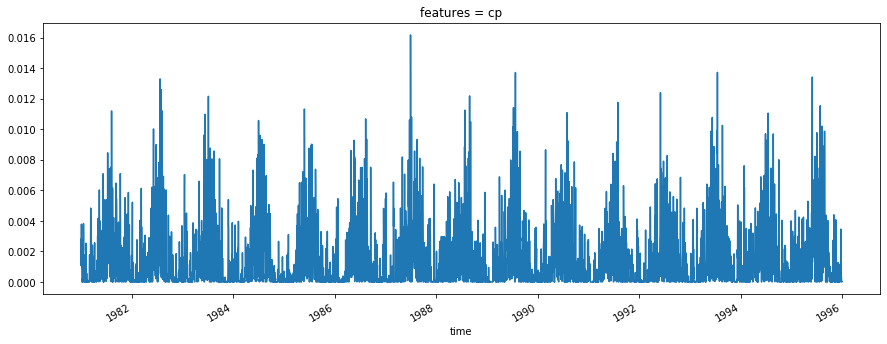

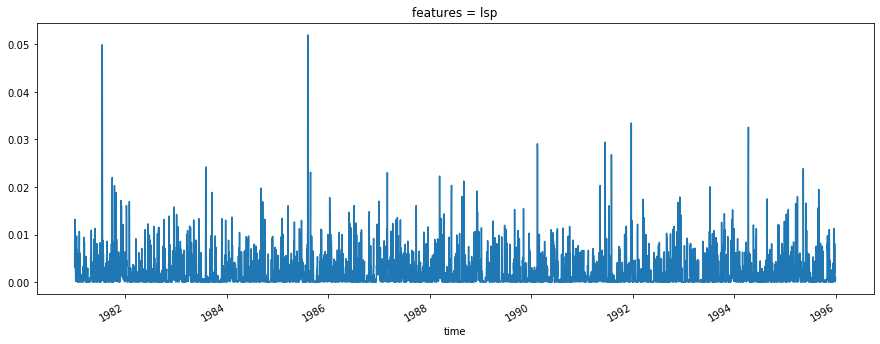

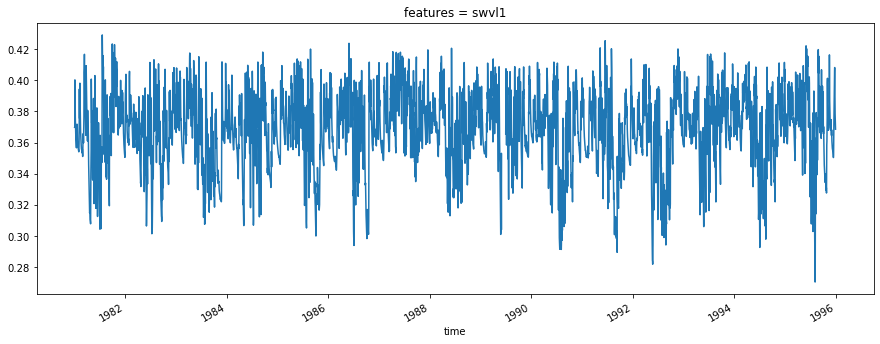

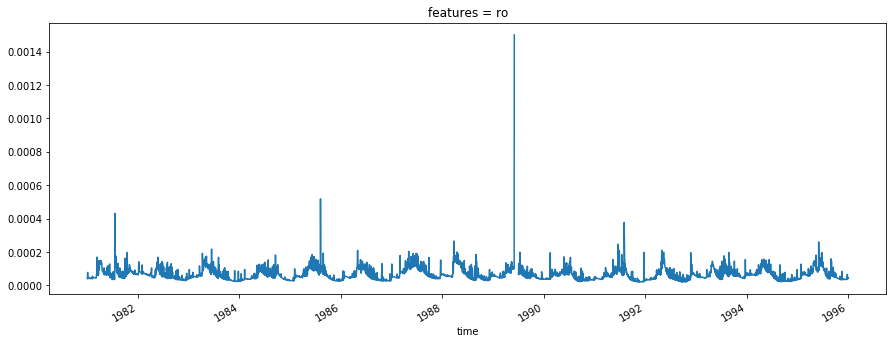

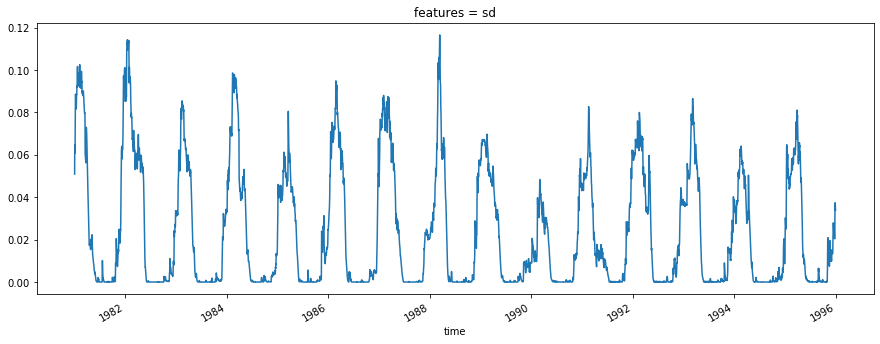

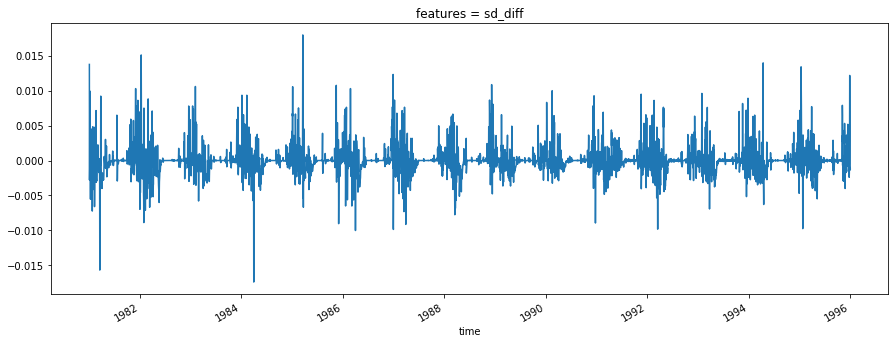

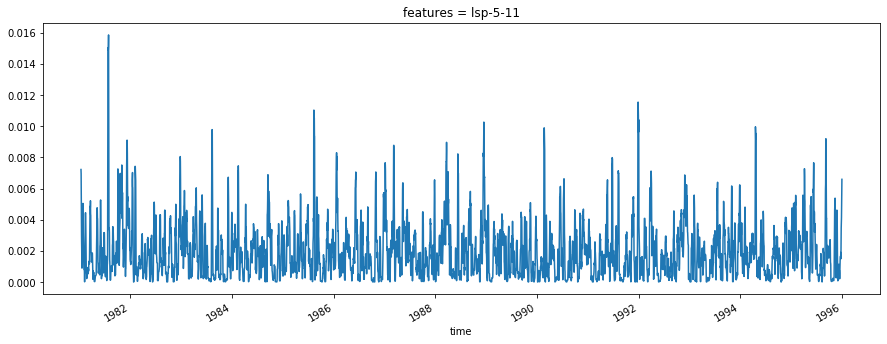

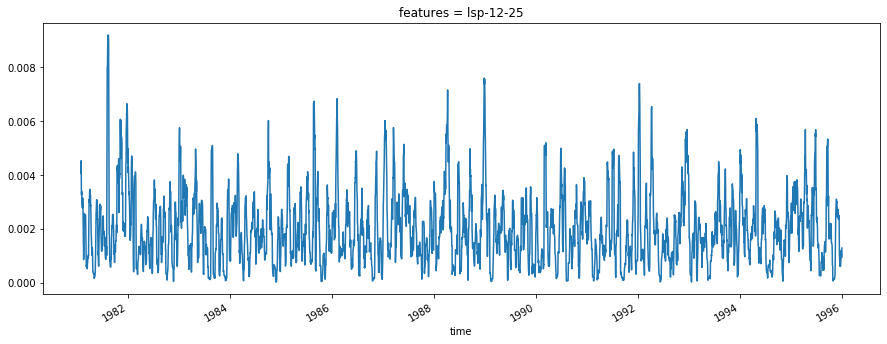

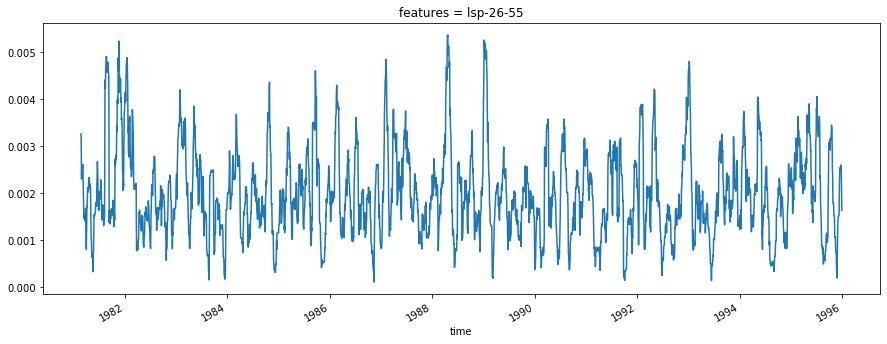

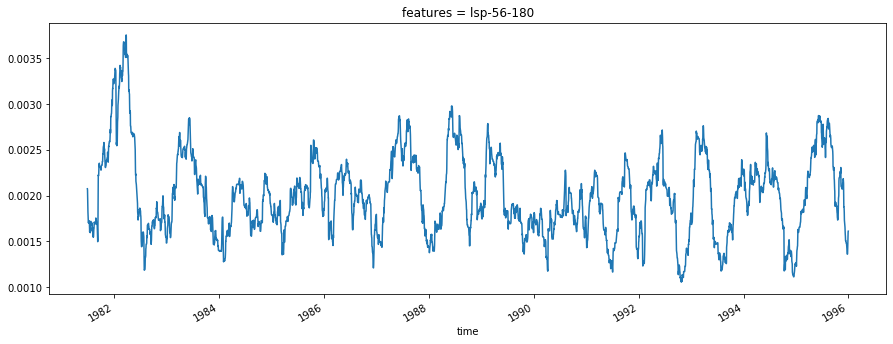

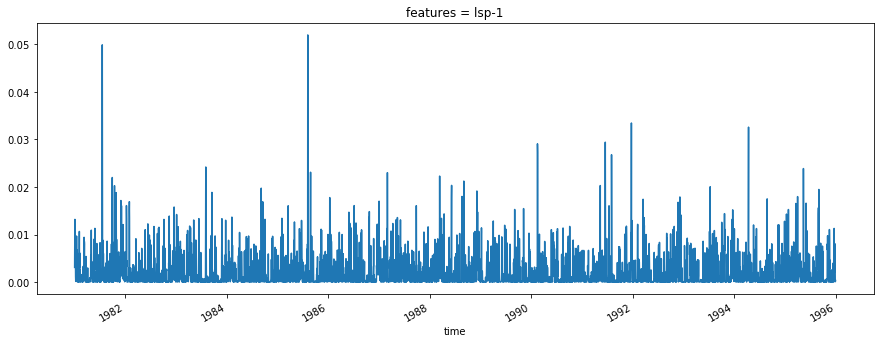

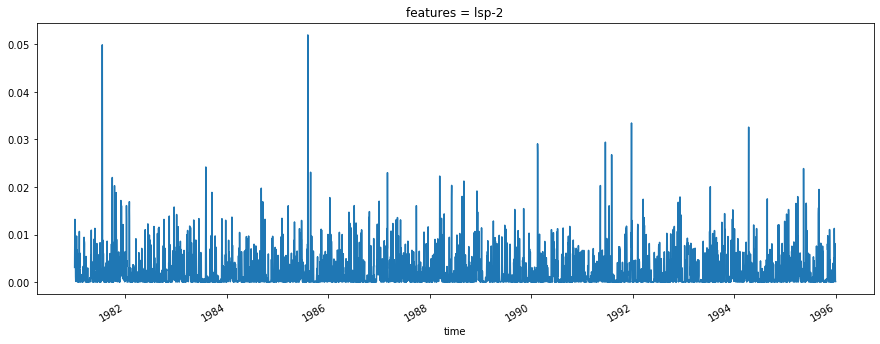

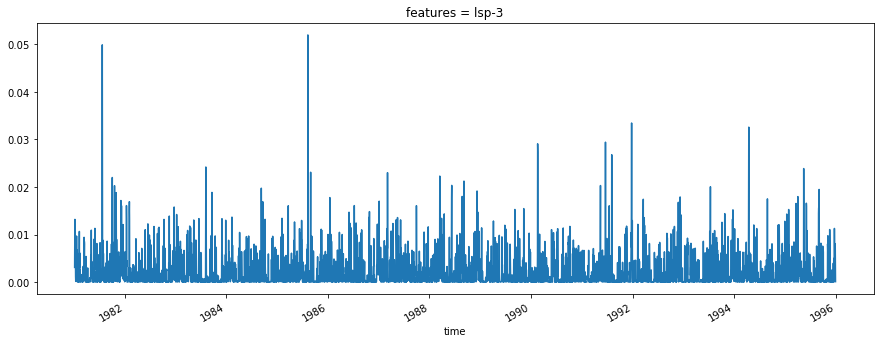

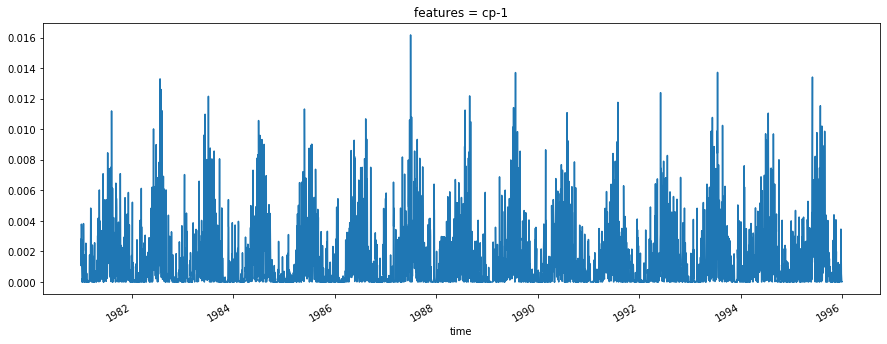

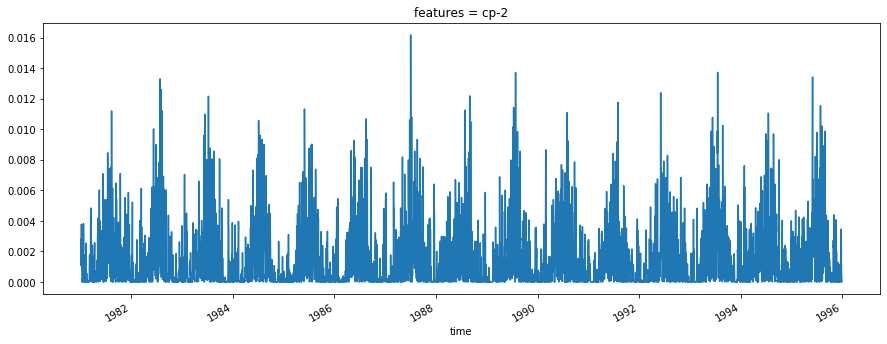

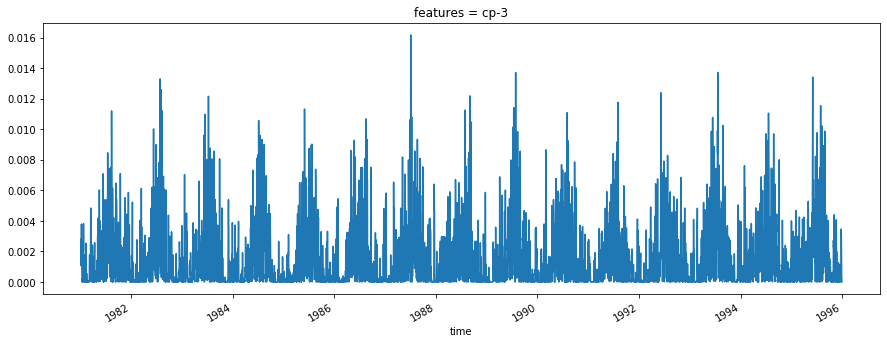

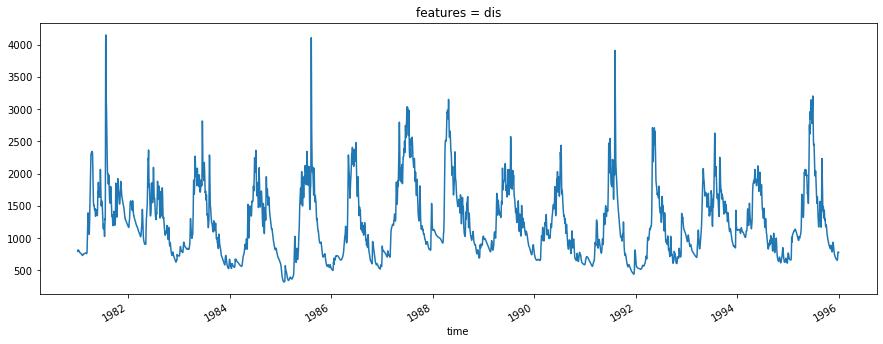

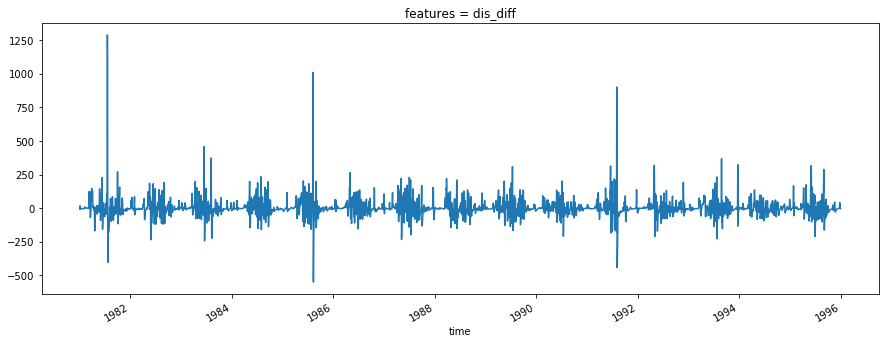

In [40]:
test1 = sample_data_1.to_array(dim='features').T
for f in test1.features:
    plt.figure(figsize=(15,5))
    test1.sel(features=f).plot(ax=plt.gca())

Correct the `ro` outlier as nanmean from the two values next to it.

In [81]:
amax_ind = np.argmax(test1.sel(features='ro').values)-1
print(sample_data_1['ro'][amax_ind])
sample_data_1['ro'][amax_ind] = np.nanmean([sample_data_1['ro'][amax_ind-1], sample_data_1['ro'][amax_ind+1]])
print(sample_data_1['ro'][amax_ind])

<xarray.DataArray 'ro' ()>
array(0.000105)
Coordinates:
    time     datetime64[ns] 1989-06-01
<xarray.DataArray 'ro' ()>
array(0.000105)
Coordinates:
    time     datetime64[ns] 1989-06-01


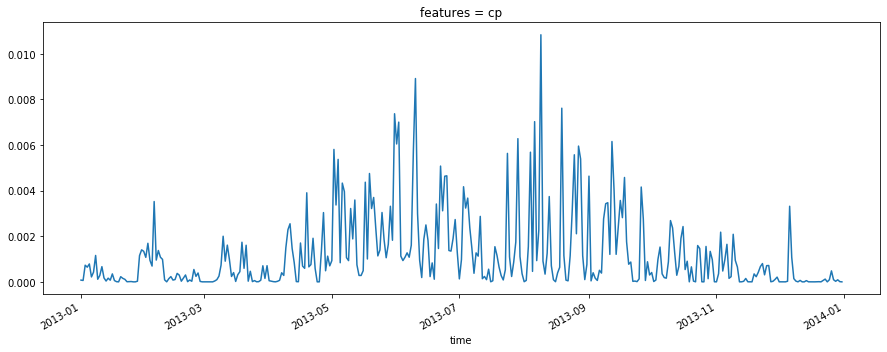

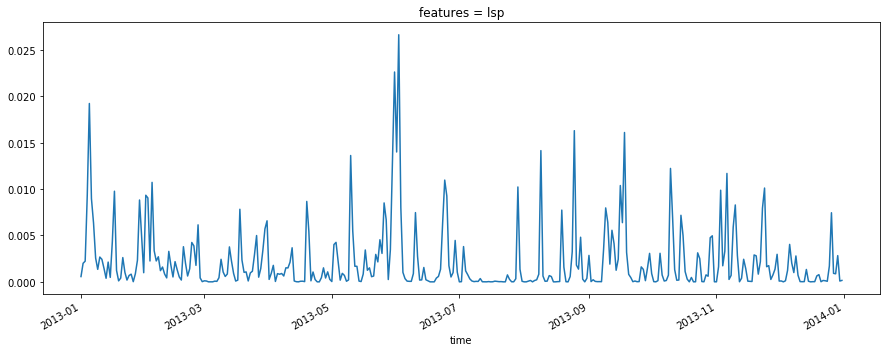

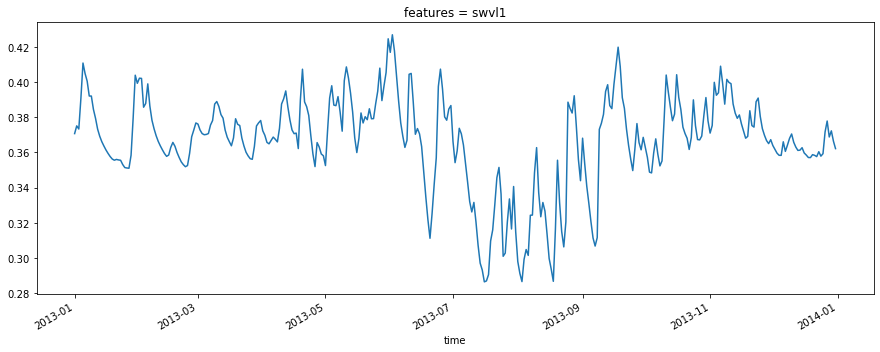

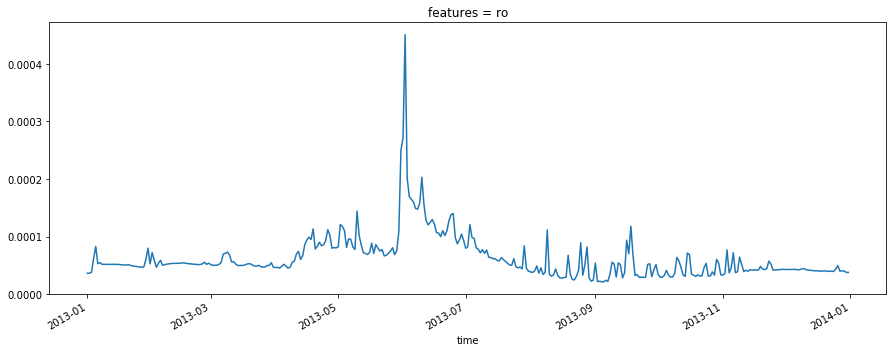

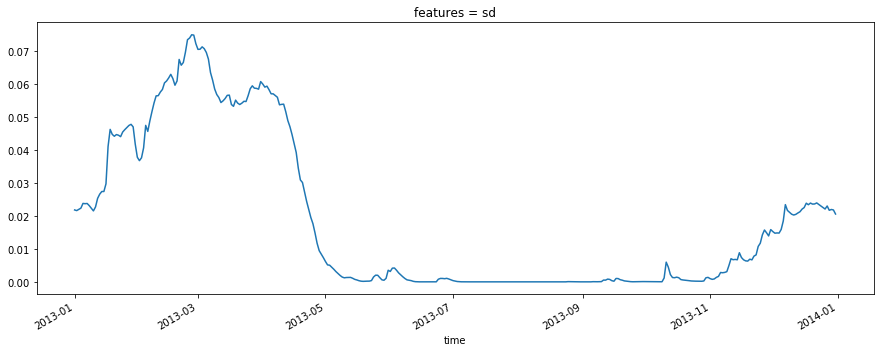

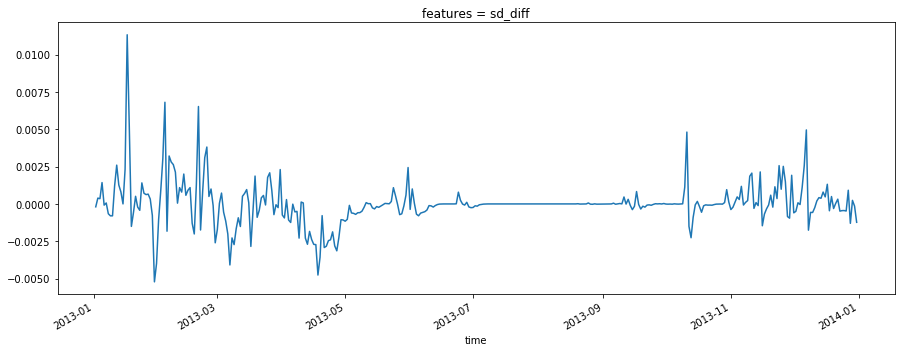

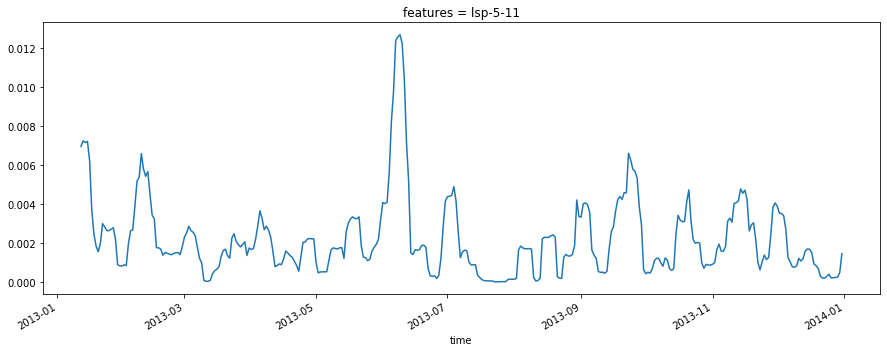

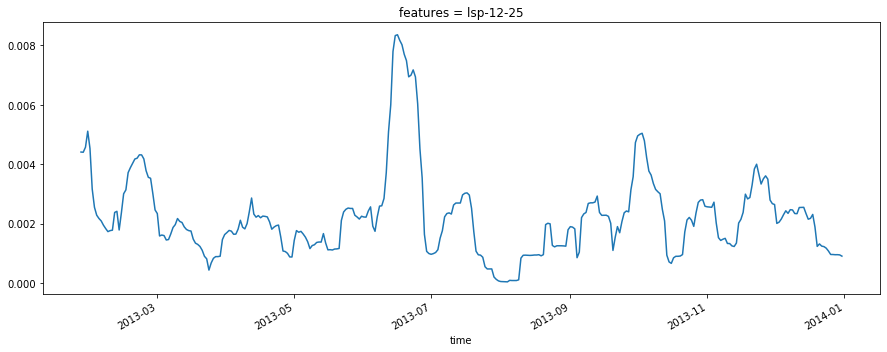

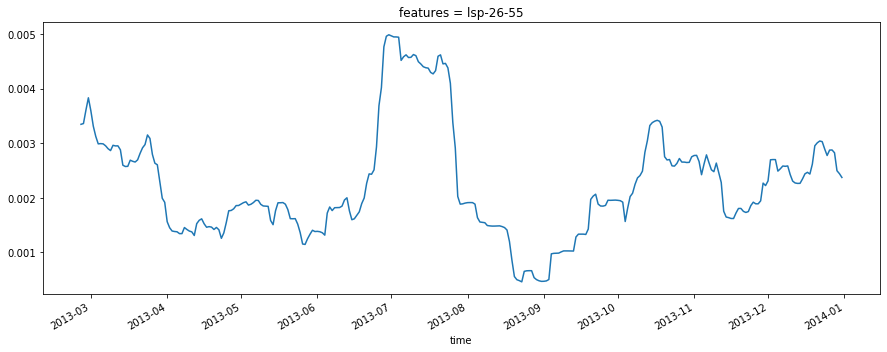

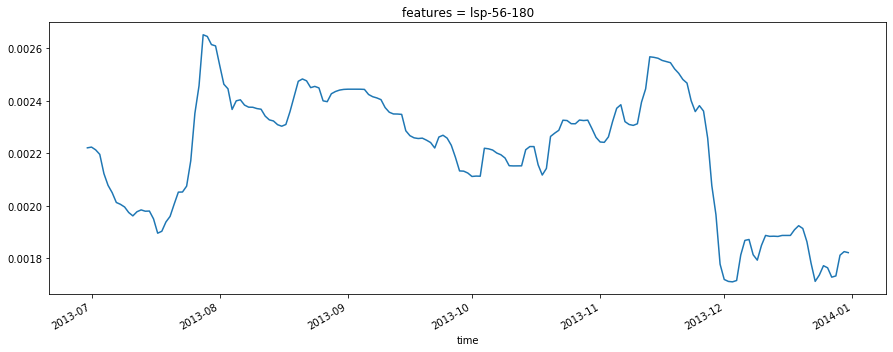

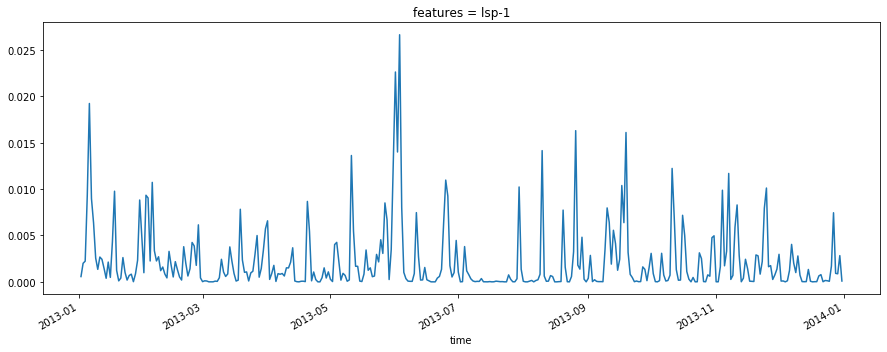

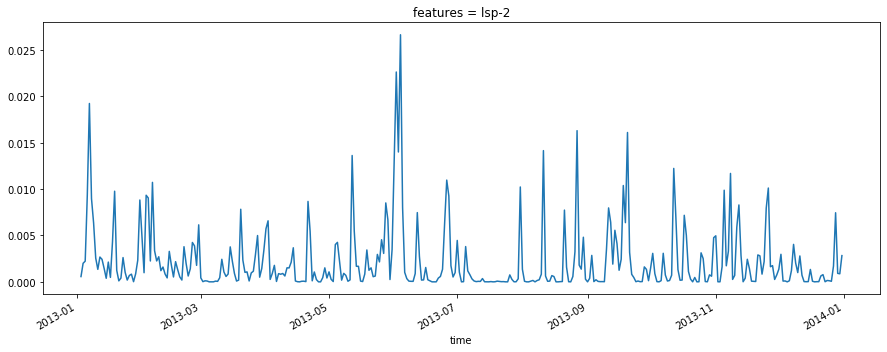

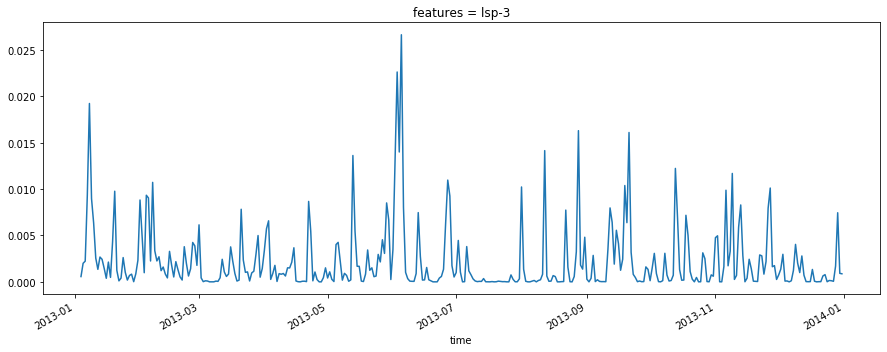

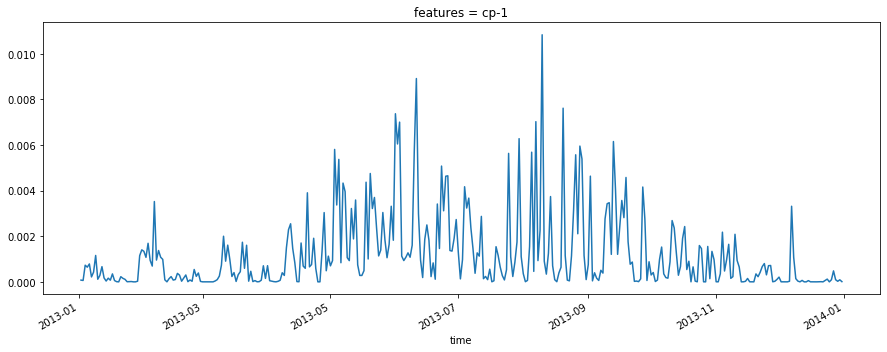

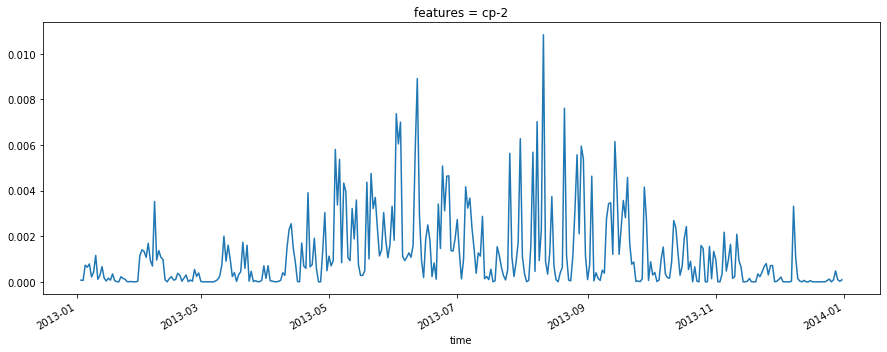

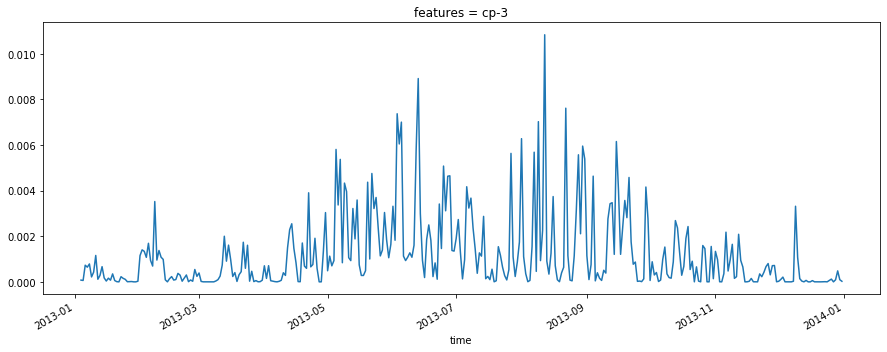

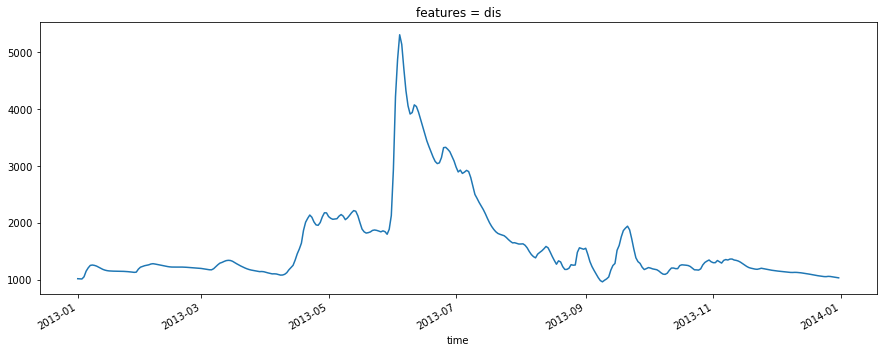

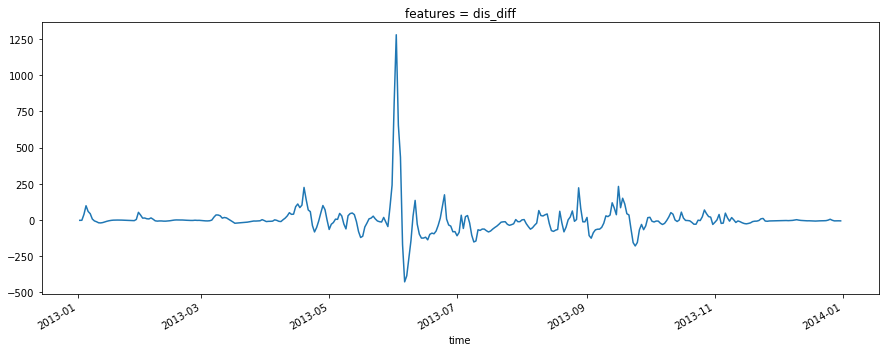

In [71]:
test2013 = sample_data_2013.to_array(dim='features').T
for f in test2013.features:
    plt.figure(figsize=(15,5))
    test2013.sel(features=f).plot(ax=plt.gca())

Save preprocessed features as .nc files.

In [82]:
sample_data_1.to_netcdf('../../data/features_xy.nc')
sample_data_2013.to_netcdf('../../data/features_xy_2013.nc')